# Florence-2-large sample usage

In [1]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
!pip -q install transformers einops timm

In [3]:
# install flash_attn 过程中因为涉及编译，需要额外一些工具
!pip -q install --upgrade setuptools

# 安装 flash_attn，不使用 build isolation
!pip -q install flash-attn --no-build-isolation

In [4]:
!pip -q install matplotlib

In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
#指定 Matplotlib 的图表在 Notebook 的单元格中直接内嵌显示，而不是弹出一个单独的窗口
%matplotlib inline

/home/huqianghui/florence_inference-finetune/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/home/huqianghui/florence_inference-finetune/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## define the prediction function

In [7]:
def run_example(task_prompt, text_input=None):
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input


    inputs = processor(text=prompt, images=image, return_tensors="pt")
    
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [8]:
image = Image.open("images/car.jpg")

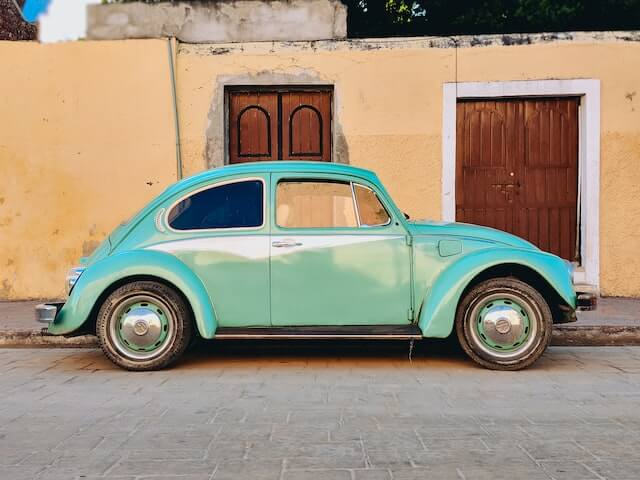

In [9]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [10]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'a green volkswagen beetle parked in front of a yellow building'}

In [11]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [12]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. The doors are made of wood and have a rustic, weathered look. The building behind the car is also painted in the same shade of yellow and has two large windows. The sky is blue and there are trees in the background. The overall mood of the image is peaceful and serene.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [13]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]], 'labels': ['car', 'door handle']}}


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

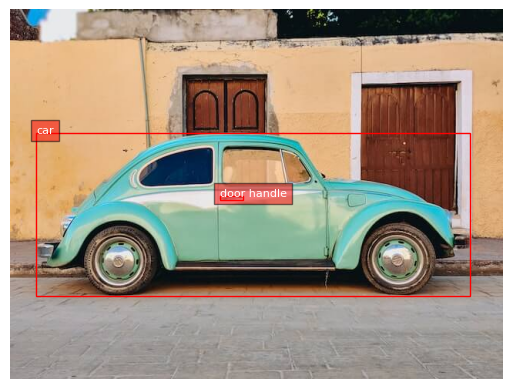

In [15]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [16]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]], 'labels': ['turquoise Volkswagen Beetle', 'door handle']}}


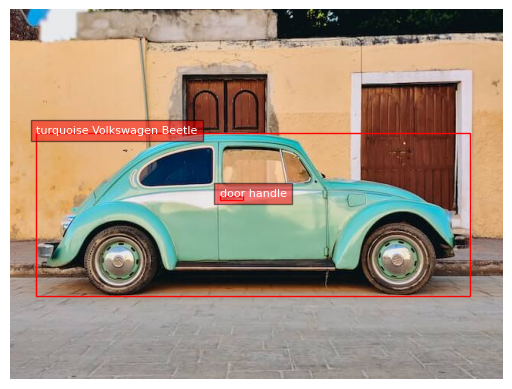

In [17]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [18]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [454.0799865722656, 276.7200012207031, 552.6400146484375, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.0800018310547, 371.2799987792969], [66.23999786376953, 266.6399841308594, 86.72000122070312, 295.91998291015625], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812], [491.1999816894531, 183.59999084472656, 519.3599853515625, 187.44000244140625], [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125], [402.8800048828125, 212.39999389648438, 409.91998291015625, 219.59999084472656], [509.1199951171875, 172.0800018310547, 514.8800048828125, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


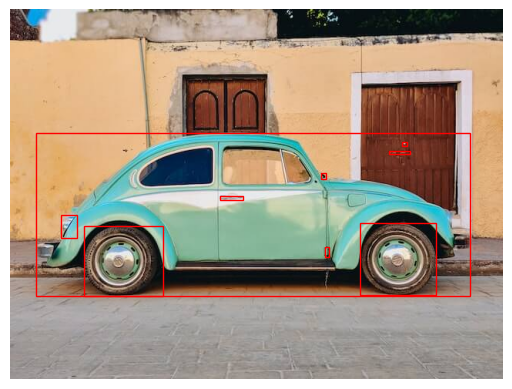

In [19]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [20]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 374.6399841308594], [1.5999999046325684, 4.559999942779541, 639.0399780273438, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


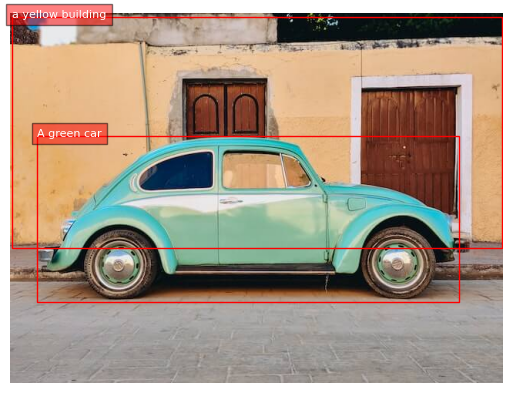

In [21]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [22]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.1999969482422, 180.8000030517578, 180.239990234375, 182.72000122070312, 180.239990234375, 187.83999633789062, 176.87998962402344, 189.75999450683594, 176.87998962402344, 192.95999145507812, 174.95999145507812, 194.87998962402344, 174.95999145507812, 198.0800018310547, 173.0399932861328, 200.63999938964844, 172.0800018310547, 203.83999633789062, 171.1199951171875, 207.0399932861328, 170.16000366210938, 210.239990234375, 169.1999969482422, 214.0800018310547, 168.239990234375, 217.9199981689453, 166.8000030517578, 221.75999450683594, 165.83999633789062, 226.239990234375, 164.87998962402344, 230.72000122070312, 163.9199981689453, 237.1199951171875, 162.95999145507812, 244.79998779296875, 162.0, 255.0399932861328, 161.0399932861328, 272.9599914550781, 160.0800018310547, 308.1600036621094, 160.0800018310547, 326.0799865722656, 161.0399932861328, 335.67999267578125, 162.0, 343.3599853515625, 162.95999145507812, 34

In [23]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

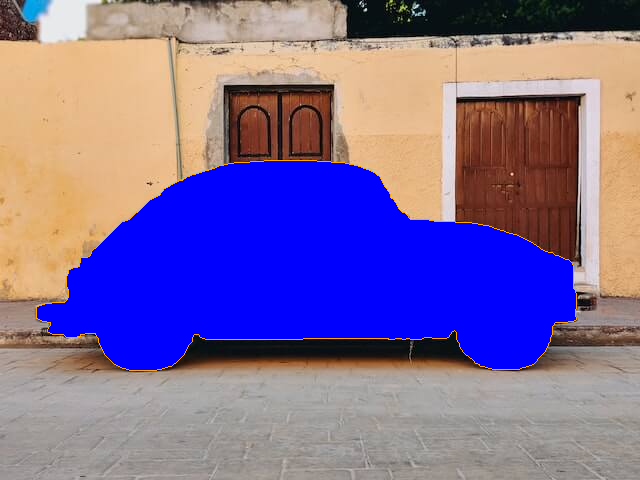

In [24]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

In [25]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.7200012207031, 288.239990234375, 473.91998291015625, 285.8399963378906, 477.1199951171875, 283.91998291015625, 479.03997802734375, 282.9599914550781, 480.9599914550781, 282.9599914550781, 484.1600036621094, 281.0400085449219, 486.7200012207031, 280.0799865722656, 489.91998291015625, 279.1199951171875, 495.03997802734375, 278.1600036621094, 512.9599609375, 278.1600036621094, 516.1599731445312, 279.1199951171875, 519.3599853515625, 281.0400085449219, 520.6400146484375, 281.0400085449219, 527.0399780273438, 283.91998291015625, 530.239990234375, 285.8399963378906, 533.4400024414062, 288.239990234375, 541.760009765625, 296.8800048828125, 544.3200073242188, 300.239990234375, 546.239990234375, 303.1199951171875, 548.1599731445312, 306.9599914550781, 548.7999877929688, 309.8399963378906, 550.0800170898438, 312.7200012207031, 550.719970703125, 317.03997802734375, 550.719970703125, 332.8800048828125, 550.0800170898438, 337.1999816894531, 548.79998

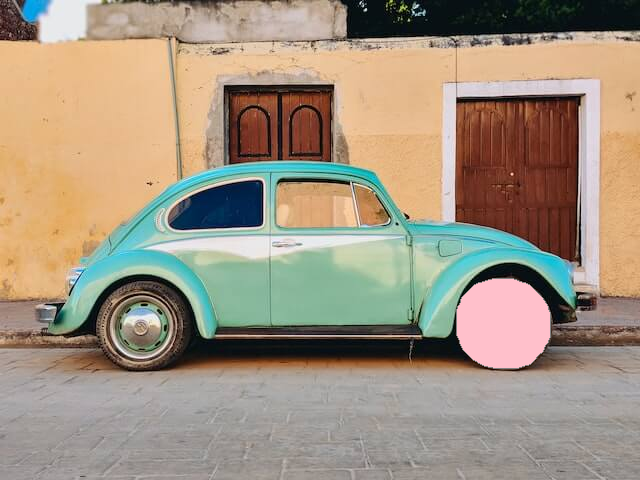

In [26]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [27]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 581.4400024414062, 373.67999267578125]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [28]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [29]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

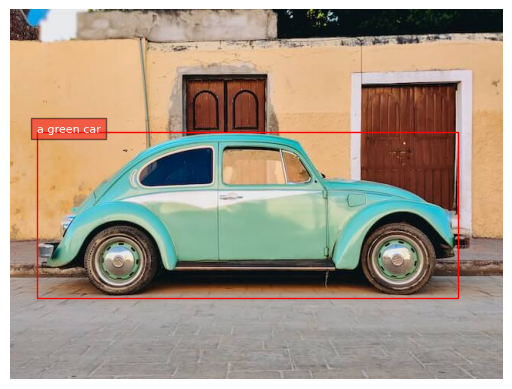

In [30]:
plot_bbox(image, bbox_results)

### region to texts

In [31]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [32]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [33]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

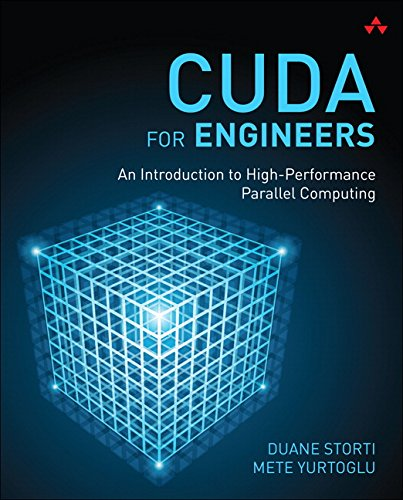

In [34]:
image

In [35]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDA\nFOR ENGINEERS\nAn Introduction to High-Performance\nParallel Computing\nDUANE STORTI\nMETE YURTOGLU\n'}

In [36]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.44650268554688, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.25, 167.44650268554688, 114.25], [144.8784942626953, 121.25, 374.9914855957031, 120.25, 374.9914855957031, 149.25, 144.8784942626953, 150.25], [115.4594955444336, 165.25, 375.7974853515625, 165.25, 375.7974853515625, 183.25, 115.4594955444336, 183.25], [239.9864959716797, 184.25, 375.7974853515625, 185.25, 375.7974853515625, 203.25, 239.9864959716797, 201.25], [265.77850341796875, 440.75, 375.7974853515625, 440.75, 375.7974853515625, 456.25, 265.77850341796875, 456.25], [250.86749267578125, 459.25, 375.7974853515625, 459.25, 375.7974853515625, 474.25, 250.86749267578125, 474.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [37]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)


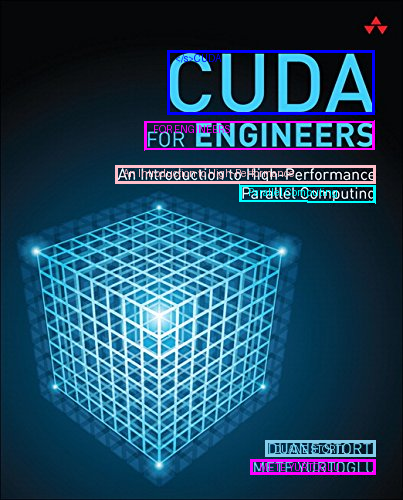

In [38]:
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])